In [ ]:
pip install shap==0.40.0

# Setting up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shap
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.random import set_seed

from preprocessing import load_loan_prepr

# Interpretability measures
from interpretability import PDP

In [2]:
def find_best_model(model, parameters, X_train, y_train): 
    clf = GridSearchCV(model, parameters, scoring=('balanced_accuracy'), cv=StratifiedKFold())
    clf.fit(X_train, y_train)

    return clf

# Calculates the per-class accuracy given predicted and true output labels.
def class_accs(y_pred, y_true):
    acc0 = ((y_pred == y_true) & (y_true == 0)).sum() / (y_true == 0).sum()
    acc1 = ((y_pred == y_true) & (y_true == 1)).sum() / (y_true == 1).sum()
    return acc0, acc1

# Prints a summary of performance metrics given predicted and true output labels.
def print_metrics(y_pred, y_true):
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    acc0, acc1 = class_accs(y_pred, y_true)
    print(f'F1 = {f1}')
    print(f'Accuracy = {acc}')
    print(f'\tclass 0: {acc0}')
    print(f'\tclass 1: {acc1}')

def classify(output: np.ndarray):
    return (output > 0.5).astype(int)

def print_errors(clf, model_name, X_test, y_test):
    y_pred = clf.predict(X_test)
    if model_name == "neural network":
        y_pred = np.reshape(y_pred, len(y_test))
        y_pred = classify(y_pred)
    
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    print("Balanced accuracy ({}) = {}".format(model_name, bal_acc))
    print_metrics(y_pred, y_test)

In [3]:
X, y, feature_names = load_loan_prepr()
seed = 3012

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

# Training models

## Scikit-learn models

In [4]:
model_names = [
    "k-nearest neighbors", 
    "decision tree classifier",
    "support vector classifier",
    ]

parameters = {
    "k-nearest neighbors": {'n_neighbors': np.arange(1, 20), 'weights': ('uniform', 'distance')}, # 'n_neighbors': np.arange(1, 364)
    "decision tree classifier": {'criterion': ('gini', 'entropy'), 'min_samples_split': np.arange(2, 20)}, # 'min_samples_split': np.arange(2, 364)
    "support vector classifier": {'C': np.geomspace(0.01, 100, 41)}
    }

models_init = {
    "k-nearest neighbors": KNeighborsClassifier(),
    "decision tree classifier": DecisionTreeClassifier(random_state=seed),
    "support vector classifier": SVC(kernel="linear")
    }

models = dict()

for model_name in model_names:
    clf = find_best_model(models_init[model_name], parameters[model_name], X_train, y_train)
    models[model_name] = clf.best_estimator_

## Neural network

In [5]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=seed, stratify=y_)

In [6]:
# Initialise neural network
BATCH_SIZE= 64
INPUT_SIZE= X_train.shape[1]

set_seed(seed)

model = Sequential()
model.add(Input(INPUT_SIZE))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.1))
# model.add(Dense(5, activation="relu"))
# model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam',
                loss="binary_crossentropy",
                metrics='binary_accuracy')

n_epochs = 86
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=n_epochs, validation_data=(X_val, y_val)) # validation_split=0.2)

models["neural network"] = model

Epoch 1/86
5/5 [==============================] - 2s 195ms/step - loss: 0.7063 - binary_accuracy: 0.6388 - val_loss: 0.7429 - val_binary_accuracy: 0.5844
Epoch 2/86
5/5 [==============================] - 0s 17ms/step - loss: 0.7092 - binary_accuracy: 0.6186 - val_loss: 0.7333 - val_binary_accuracy: 0.5844
Epoch 3/86
5/5 [==============================] - 0s 17ms/step - loss: 0.6833 - binary_accuracy: 0.6453 - val_loss: 0.7242 - val_binary_accuracy: 0.6234
Epoch 4/86
5/5 [==============================] - 0s 14ms/step - loss: 0.7078 - binary_accuracy: 0.6132 - val_loss: 0.7154 - val_binary_accuracy: 0.6494
Epoch 5/86
5/5 [==============================] - 0s 15ms/step - loss: 0.6848 - binary_accuracy: 0.6666 - val_loss: 0.7072 - val_binary_accuracy: 0.6494
Epoch 6/86
5/5 [==============================] - 0s 13ms/step - loss: 0.6751 - binary_accuracy: 0.6853 - val_loss: 0.6992 - val_binary_accuracy: 0.6494
Epoch 7/86
5/5 [==============================] - 0s 13ms/step - loss: 0.6592 - b

## Errors

In [7]:
for model_name in models.keys():
    print_errors(models[model_name], model_name, X_test, y_test)

Balanced accuracy (k-nearest neighbors) = 0.7257575757575758
F1 = 0.8843537414965986
Accuracy = 0.8229166666666666
	class 0: 0.4666666666666667
	class 1: 0.9848484848484849
Balanced accuracy (decision tree classifier) = 0.6681818181818182
F1 = 0.7969924812030075
Accuracy = 0.71875
	class 0: 0.5333333333333333
	class 1: 0.803030303030303
Balanced accuracy (support vector classifier) = 0.7333333333333334
F1 = 0.8918918918918919
Accuracy = 0.8333333333333334
	class 0: 0.4666666666666667
	class 1: 1.0
Balanced accuracy (neural network) = 0.7424242424242424
F1 = 0.8904109589041096
Accuracy = 0.8333333333333334
	class 0: 0.5
	class 1: 0.9848484848484849


# Intrinsic interpretability

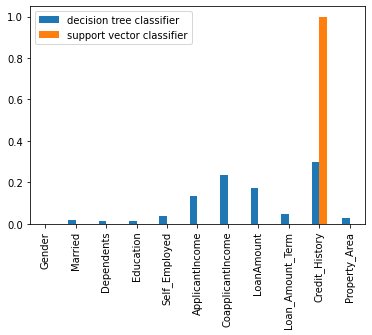

In [16]:
dtr_feat_imps = models["decision tree classifier"].feature_importances_

svc_coefs = models["support vector classifier"].coef_[0]
svc_feat_imps = np.abs(svc_coefs) / np.sum(np.abs(svc_coefs))

intr_feat_imps = pd.DataFrame({"decision tree classifier": dtr_feat_imps, "support vector classifier": svc_feat_imps}, index=feature_names)
intr_feat_imps.plot.bar()
plt.show()

# Partial dependence plot

k-nearest neighbors


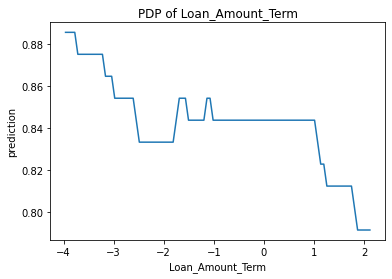

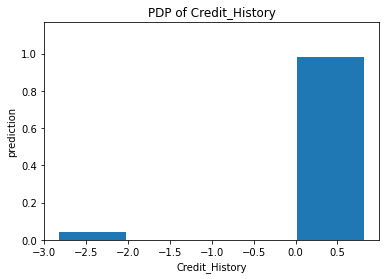

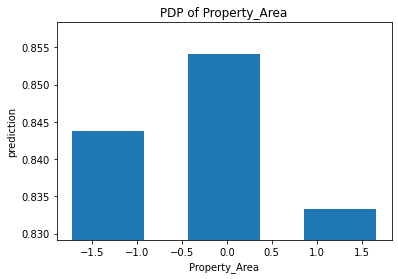

decision tree classifier


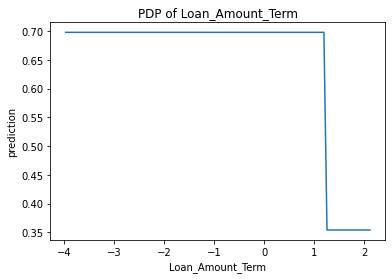

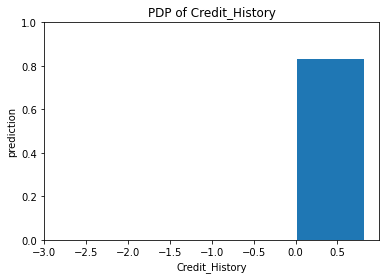

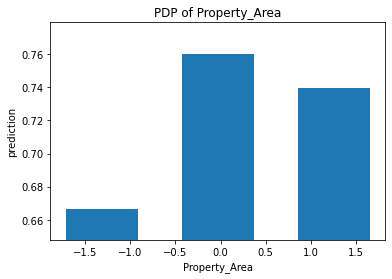

support vector classifier


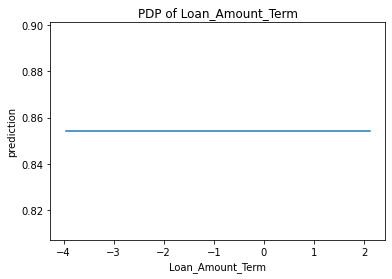

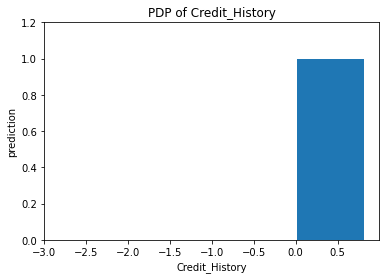

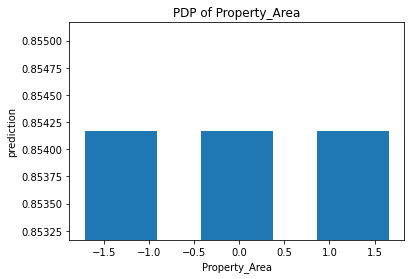

neural network


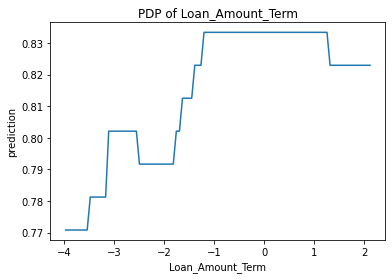

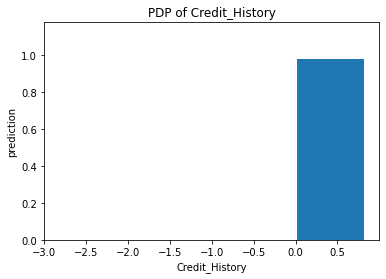

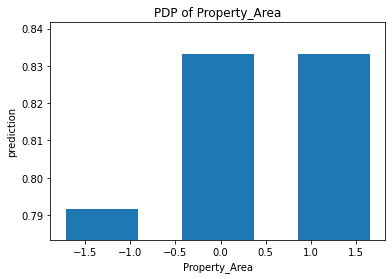

In [ ]:
categorical = [True, True, True, True, True, False, False, False, False, True, True]

for model_name in models.keys():
    model = models[model_name]
    print(model_name)

    for i in range(8, 11): # range(X_test.shape[1]):
        PDP(i, feature_names[i], model, X_test, y_test, categorical=categorical[i])
        plt.show()
        plt.close()

Smoother plots if we use probabilities

# SHAP

## Instance-based interpretability

In [10]:
explainers = dict()

for model_name in models.keys():
  model = models[model_name]

  if model_name == "neural network":
    def nn_predict(X):
      y_pred = model.predict(X)
      y_pred = np.reshape(y_pred, X.shape[0])
      return classify(np.array(y_pred))

    explainers[model_name] = shap.KernelExplainer(nn_predict, shap.sample(X_train, 200))
  else:
    explainers[model_name] = shap.KernelExplainer(model.predict, shap.sample(X_train, 200))

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
idx = 4
model_name = "decision tree classifier"

X_test_df = pd.DataFrame(X_test, columns=feature_names)

explainer = explainers[model_name]
shap_test = explainer.shap_values(X_test_df.iloc[idx])

# PLOT SHAPLEY VALUES IN NORMAL WAY

shap.initjs()
shap.force_plot(explainer.expected_value, shap_test, X_test_df.iloc[idx])
# shap.force_plot(explainer.expected_value[1], shap_test[1], X_test_df.iloc[idx]) # for decision trees

## Global interpetation

In [11]:
shap_values_all = dict()
X_test_df = pd.DataFrame(X_test, columns=feature_names)

for model_name in models.keys():
    print(model_name)
    explainer = explainers[model_name]

    shap_values = explainer.shap_values(X_test_df.iloc[:7])
    shap_values_all[model_name] = shap_values

k-nearest neighbors


  0%|          | 0/7 [00:00<?, ?it/s]

decision tree classifier


  0%|          | 0/7 [00:00<?, ?it/s]

support vector classifier


  0%|          | 0/7 [00:00<?, ?it/s]

neural network


  0%|          | 0/7 [00:00<?, ?it/s]

In [12]:
shapley_feat_imps = pd.DataFrame(index=feature_names)

for model_name in models.keys():
  shap_values = shap_values_all[model_name]
  feat_imps = np.mean(np.abs(shap_values), axis=0)
  feat_imps /= np.sum(feat_imps)
  shapley_feat_imps.insert(0, model_name, feat_imps)

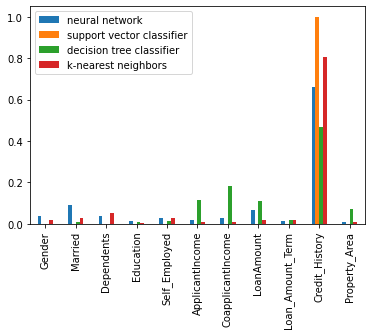

In [13]:
shapley_feat_imps.plot.bar()
plt.show()

# Comparing feature importances

Lai et al.

In [83]:
intr_mapper = dict()
shapley_mapper = dict()

for model_name in models.keys():
    intr_mapper[model_name] = model_name + " (intrinsic)"
    shapley_mapper[model_name] = model_name + " (SHAP)"

intr_feat_imps.rename(columns=intr_mapper, errors="ignore")
shapley_feat_imps.rename(columns=shapley_mapper)

all_feat_imps = pd.concat([intr_feat_imps.rename(columns=intr_mapper, errors="ignore"), shapley_feat_imps.rename(columns=shapley_mapper)], axis=1)

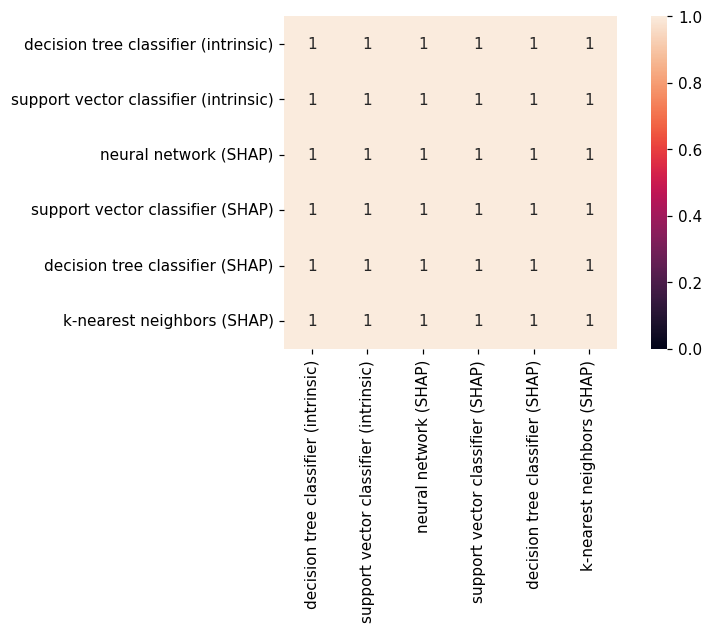

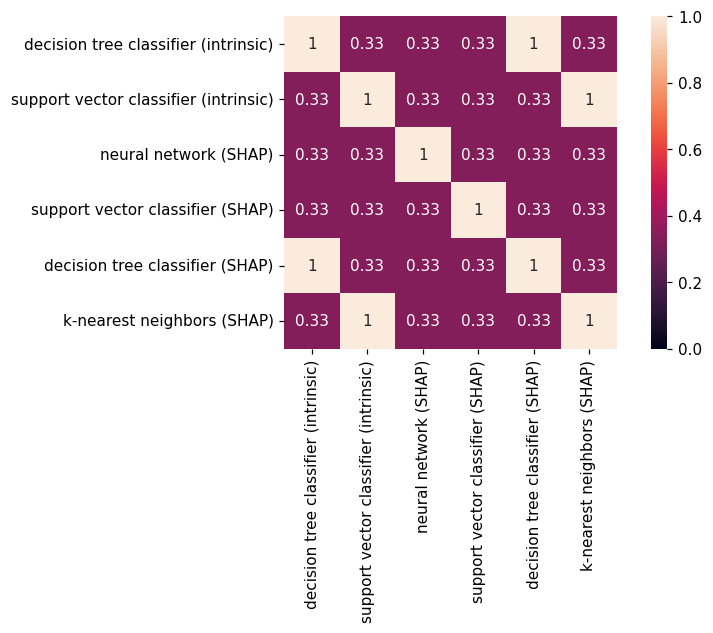

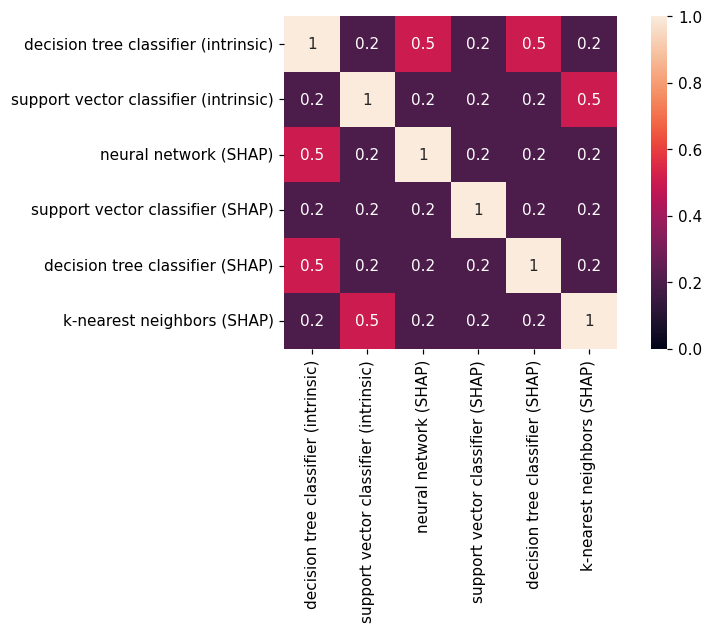

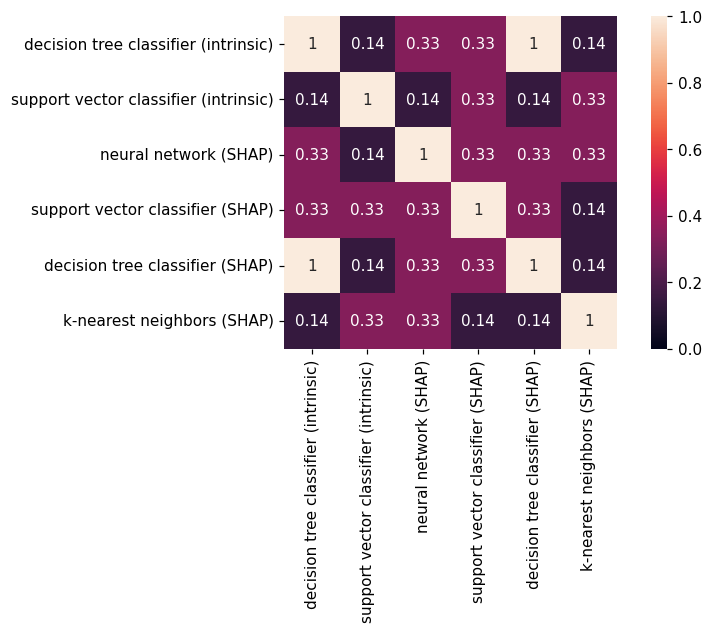

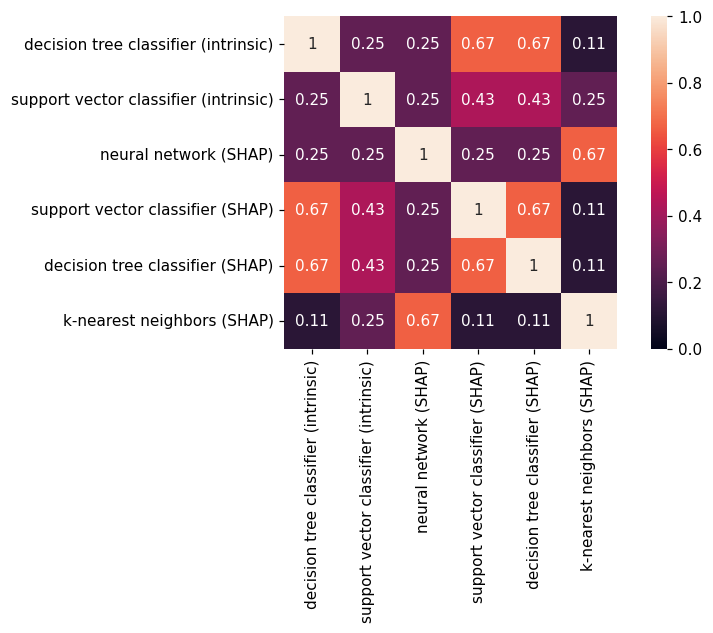

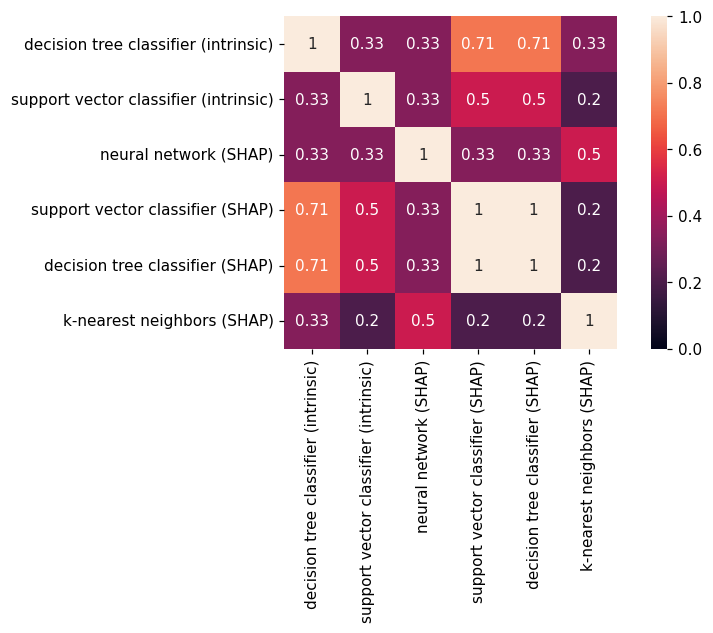

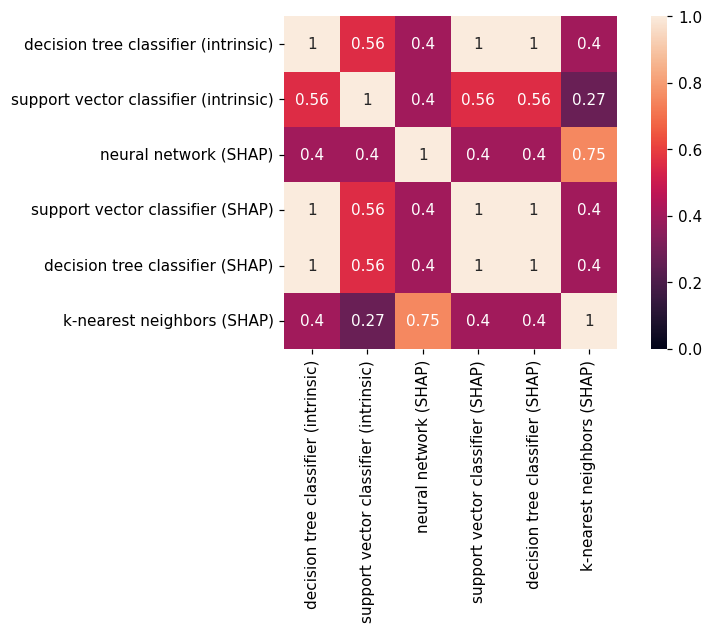

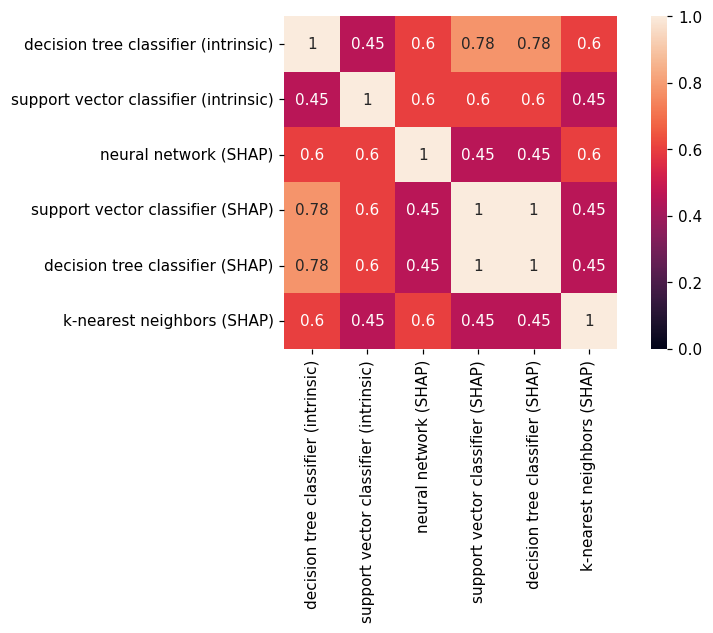

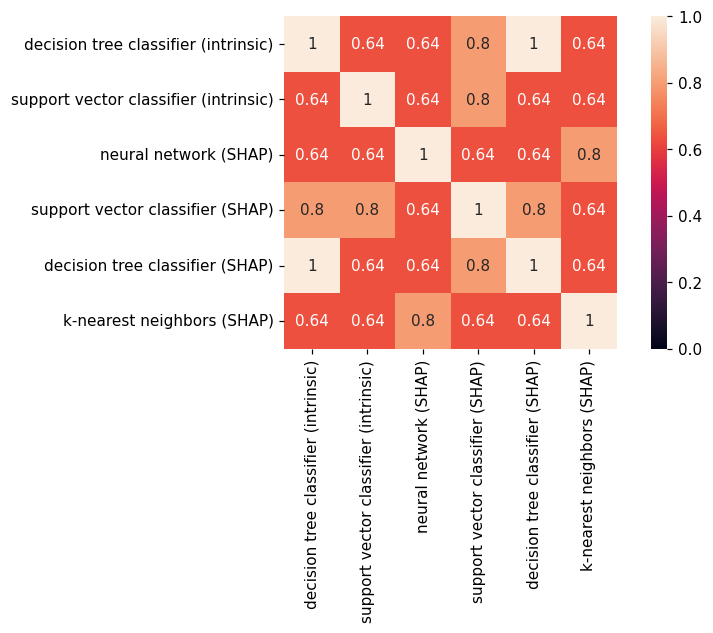

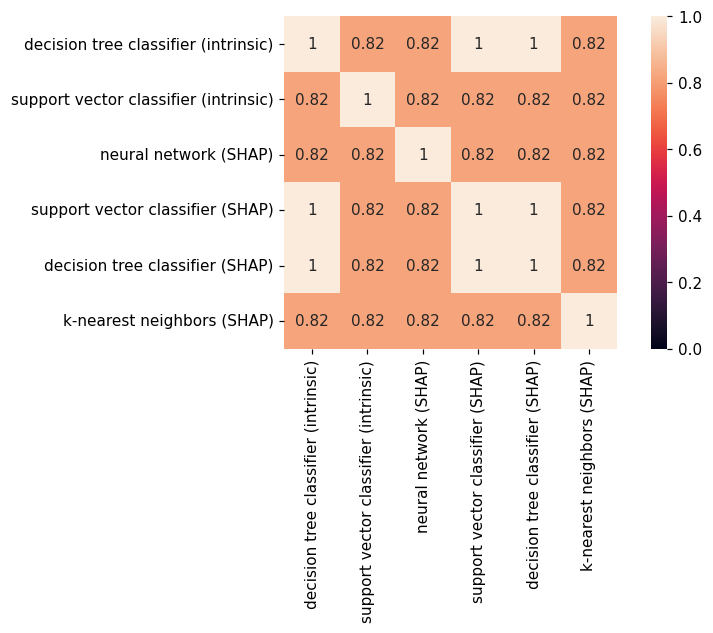

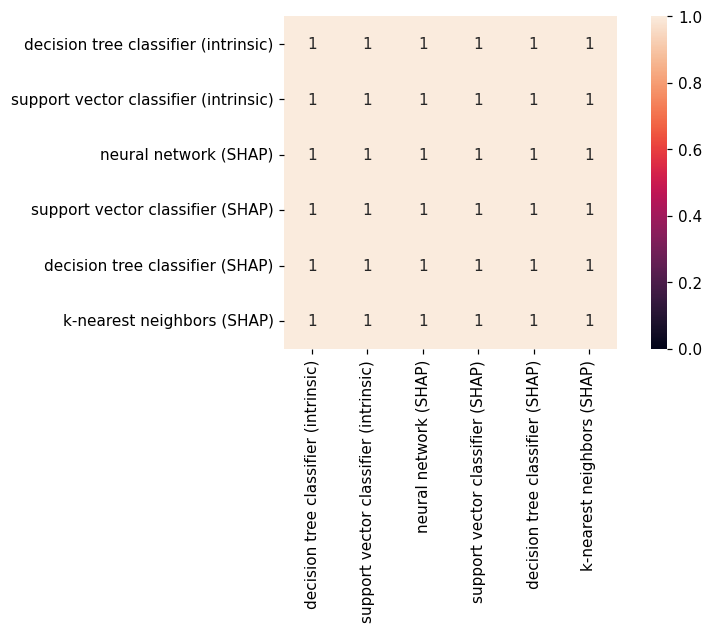

In [92]:
all_feat_imps_columns = all_feat_imps.columns
jaccard_sim = pd.DataFrame(np.zeros((len(all_feat_imps_columns), len(all_feat_imps_columns))), index=all_feat_imps_columns, columns=all_feat_imps_columns)

for k in range(1, len(feature_names) + 1):
    for column_name_1 in all_feat_imps_columns:
        for column_name_2 in all_feat_imps_columns:
            feat_imps_1 = np.array(all_feat_imps[column_name_1])
            feat_imps_2 = np.array(all_feat_imps[column_name_2])

            top_features_1 = feature_names[np.argsort(feat_imps_1)][::-1][:k]
            top_features_2 = feature_names[np.argsort(feat_imps_2)][::-1][:k]

            union = len(top_features_1)
            intersec = 0

            for feature in top_features_1:
                if feature in top_features_2:
                    intersec += 1
                else: 
                    union += 1

            jaccard_sim[column_name_1][column_name_2] = intersec / union

    f, ax = plt.subplots(figsize=(8, 4), dpi=110)
    sns.heatmap(jaccard_sim, vmin=0.0, vmax=1.0, annot=True, square=True)
    plt.show()

# Counterfactuals

In [ ]:
categorical = [True, True, True, True, True, False, False, False, False, True, True] # meegeven bij preprocessing module
categorical_values = list()

for i in range(len(feature_names)):
  if categorical[i]:
    categorical_values.append(np.unique(X_train[:, i]))
  else:
    categorical_values.append(None)

In [ ]:
def postproces_nn(y_pred_nn):
  y_pred = classify(y_pred_nn)
  return np.reshape(y_pred, y_pred.shape[0])

In [ ]:
print(feature_names)

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')


In [ ]:
instance_idx = -6
n_counterfactuals = 10
update_time = 5000
model_name = "decision tree classifier" 
limit_varied_features = True
# features_to_vary = categorical
features_to_vary = [True] * len(feature_names)
# features_to_vary = [False, False, False, True, True, True, True, True, True, False, True]

model = models[model_name]

np.random.seed(seed)

instance = X_test[instance_idx]
instance = np.reshape(instance, (1, len(feature_names)))

if model_name == "neural network":
  original_pred = model.predict(instance)
  original_pred = postproces_nn(original_pred)[0]
else:
  original_pred = model.predict(instance)[0]

print(f"Original prediction: {original_pred}")

counterfactuals = instance * np.ones((n_counterfactuals, len(feature_names)))
counterfactual_losses = np.ones(n_counterfactuals) * 100

update_counter = 0
total_counter = 0

while update_counter < update_time:
  counterfactual_found = False
  counter = 0
  prev_instance = np.copy(instance)

  while counter < 100 and not counterfactual_found:
    # Change a feature value randomly
    feature_idx = np.random.randint(len(feature_names))

    while not features_to_vary[feature_idx]:
      feature_idx = np.random.randint(len(feature_names))

    if categorical[feature_idx]:
      new_value = np.random.choice(categorical_values[feature_idx])
    else:
      minimum_value = np.min(X_train[:,feature_idx]) # extend this range
      maximum_value = np.max(X_train[:,feature_idx])
      new_value = np.random.random() * (maximum_value - minimum_value) + minimum_value
    
    new_instance = np.copy(prev_instance)
    new_instance[:,feature_idx] = new_value

    # Make a new prediction
    if model_name == "neural network":
      new_pred = model.predict(new_instance)
      new_pred = postproces_nn(new_pred)[0]
    else:
      new_pred = model.predict(new_instance)[0]
    
    # Check if new instance is a counterfactual
    if new_pred != original_pred:
      counterfactual_found = True
      counterfactual_loss = np.sum(np.abs(new_instance - instance))

      # Check if counterfactual already in the set
      # not (new_instance == counterfactuals).all(axis=1).any()

      # Standard counterfactual to replace is the one with the biggest loss value
      idx_to_replace = np.argmax(counterfactual_losses)

      # If varied features are limited we replace the instance with the same
      # varied features
      if limit_varied_features:
        counterfactuals_varied_features = ((counterfactuals - instance) != 0.0)
        varied_features = ((new_instance - instance) != 0.0)
      
        counterfactuals_with_same_varied_features = (varied_features == counterfactuals_varied_features).all(axis=1)

        if counterfactuals_with_same_varied_features.any():
          idx_to_replace = np.where(counterfactuals_with_same_varied_features)
      
      # Check if new loss value is smaller than the one we want to replace
      if counterfactual_loss < counterfactual_losses[idx_to_replace]:
        # Replace counterfactual in set with found instance
        counterfactuals[idx_to_replace] = new_instance
        counterfactual_losses[idx_to_replace] = counterfactual_loss
        
        print("---------------------------------------------------------------")
        print(f"Counts total: {total_counter}")
        print(f"Counts since last update: {update_counter}")
        print(f"Counterfactual losses: {counterfactual_losses}")

        update_counter = 0
    
    prev_instance = np.copy(new_instance)

    counter += 1
  update_counter += 1
  total_counter += 1
  if not (total_counter % 1000):
    print("---------------------------------------------------------------")
    print(f"Total counts: {total_counter}")

print("---------------------------------------------------------------")
print(f"Total counts: {total_counter}")
print(f"Counts since last update: {update_counter}")

sort_indices = np.argsort(counterfactual_losses)
counterfactual_losses = counterfactual_losses[sort_indices]
counterfactuals = counterfactuals[sort_indices]

print(f"Counterfactual_losses: {counterfactual_losses}")

# Post processing step: remove all original instances from counterfactuals

Original prediction: 1.0
---------------------------------------------------------------
Counts total: 0
Counts since last update: 0
Counterfactual losses: [  6.30430699 100.         100.         100.         100.
 100.         100.         100.         100.         100.        ]
---------------------------------------------------------------
Counts total: 1
Counts since last update: 1
Counterfactual losses: [  6.30430699   6.88832969 100.         100.         100.
 100.         100.         100.         100.         100.        ]
---------------------------------------------------------------
Counts total: 2
Counts since last update: 1
Counterfactual losses: [  6.30430699   6.88832969  10.44224299 100.         100.
 100.         100.         100.         100.         100.        ]
---------------------------------------------------------------
Counts total: 3
Counts since last update: 1
Counterfactual losses: [  6.30430699   6.88832969  10.44224299   4.12267181 100.
 100.         100.

In [ ]:
print((counterfactuals - instance) != 0)

[[False False False False False False False False False  True False]
 [False False False False False False False False  True  True False]
 [False False False False False  True False False False  True False]
 [False False False False False False  True False False  True False]
 [False False False False False False False  True False  True False]
 [False False False False False  True False  True False  True False]
 [False False False False False False  True False  True  True False]
 [False False False False False False  True  True False  True False]
 [False False False False False False False  True  True  True False]
 [False False False False False  True False False  True  True False]]



# Prutsen

    for key in history.history.keys():
        plt.plot(np.arange(1, n_epochs+1), history.history[key], label=key)
    plt.legend()
    plt.show()

    print(np.argmin(history.history['val_loss']))
    print(np.where(history.history['val_loss'] == np.min(history.history['val_loss'])))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=90a57419-7b7b-4aa4-8a97-858f9f98a849' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>